In [21]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [22]:
# Enhanced Data Preparation
train_dir = "../../data4/train"
validation_dir = "../../data4/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

num_classes = train_generator.num_classes

Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [23]:
# Updated Hybrid Model with Dropout
def build_hybrid_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    resnet_base.trainable = False
    vgg_base.trainable = False
    inception_base.trainable = False

    input_tensor = Input(shape=(224, 224, 3))
    resnet_output = GlobalAveragePooling2D()(resnet_base(input_tensor))
    vgg_output = GlobalAveragePooling2D()(vgg_base(input_tensor))
    inception_output = GlobalAveragePooling2D()(inception_base(input_tensor))

    merged = concatenate([resnet_output, vgg_output, inception_output])
    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.5)(x)  # Dropout for regularization
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [24]:
model = build_hybrid_model(num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_15[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 5, 5,      │ 21,802,784 │ input_layer_15[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 4608)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │  2,359,808 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      2,052 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,467,044 (238.29 MB)

 Trainable params: 2,361,860 (9.01 MB)

 Non-trainable params: 60,105,184 (229.28 MB)

In [25]:
# Callbacks: Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

# Compile and Train
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler]
)

# Save Model
model.save("../../models/optimized_hybrid_model.keras")


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1170s 6s/step - accuracy: 0.5109 - loss: 1.4488 - val_accuracy: 0.6717 - val_loss: 0.7981 - learning_rate: 0.0010
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1182s 6s/step - accuracy: 0.6403 - loss: 0.8693 - val_accuracy: 0.6639 - val_loss: 0.7685 - learning_rate: 0.0010
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1207s 6s/step - accuracy: 0.6302 - loss: 0.8699 - val_accuracy: 0.7022 - val_loss: 0.7411 - learning_rate: 0.0010
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1203s 6s/step - accuracy: 0.6438 - loss: 0.8341 - val_accuracy: 0.6740 - val_loss: 0.7443 - learning_rate: 0.0010
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1203s 6s/step - accuracy: 0.6444 - loss: 0.8375 - val_accuracy: 0.6950 - val_loss: 0.7420 - learning_rate: 0.0010
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1212s 6s/step - accuracy: 0.6461 - loss: 0.8158 - val_accuracy: 0.6890 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1205s 6s/step - accuracy: 0.6802 - l

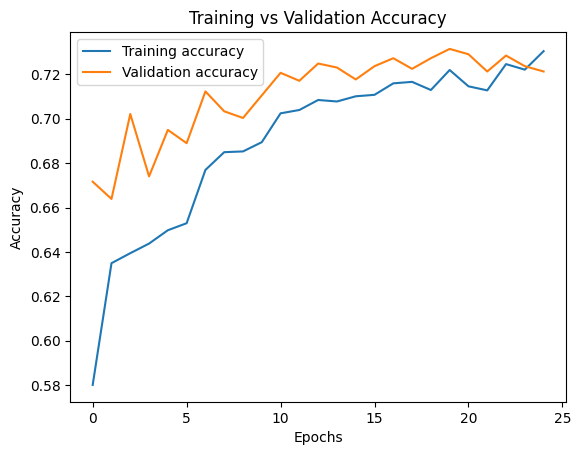

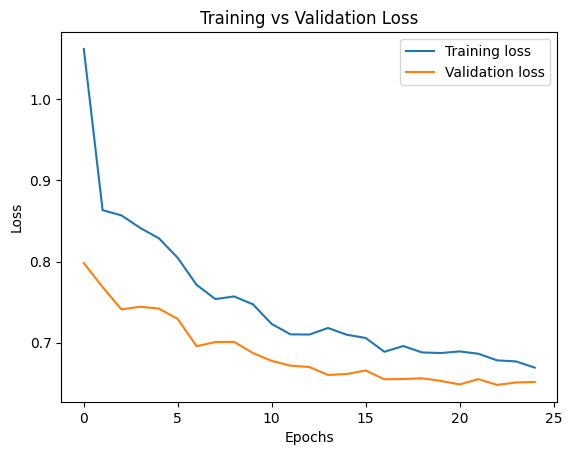

In [26]:
import matplotlib.pyplot as plt

def plot_training_results(history, metrics=["accuracy", "loss"]):
    """
    Plots training and validation metrics for each metric in the list.

    Parameters:
    - history: The history object returned by model.fit().
    - metrics: A list of metric names to plot (e.g., ["accuracy", "loss"]).
    """
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

# Plot accuracy and loss for the initial training
plot_training_results(history, metrics=["accuracy", "loss"])


In [ ]:
# Fine-Tuning the Hybrid Model
def fine_tune_model(model, train_generator, validation_generator, base_models, fine_tune_layers, learning_rate=1e-5, epochs=10):
    """
    Fine-tune the hybrid model by unfreezing specific layers of the base models.
    
    Parameters:
    - model: The hybrid model to fine-tune.
    - train_generator: Training data generator.
    - validation_generator: Validation data generator.
    - base_models: A list of base model instances [resnet_base, vgg_base, inception_base].
    - fine_tune_layers: A list of numbers specifying the number of layers to unfreeze for each base model.
    - learning_rate: Learning rate for fine-tuning.
    - epochs: Number of epochs for fine-tuning.
    """
    # Unfreeze the last few layers of each base model
    for base_model, layers_to_unfreeze in zip(base_models, fine_tune_layers):
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True

    # Recompile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 'AUC'])

    # Fine-tune the model
    fine_tune_history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler]
    )
    return fine_tune_history

# Get the base models from the hybrid model
resnet_base = model.get_layer("resnet50")  # Replace with the actual ResNet layer name
vgg_base = model.get_layer("vgg16")        # Replace with the actual VGG layer name
inception_base = model.get_layer("inception_v3")  # Replace with the actual Inception layer name

# Specify how many layers to unfreeze for fine-tuning
fine_tune_layers = [10, 4, 5]  # Example: last 10 layers of ResNet, 4 layers of VGG, 5 layers of Inception

# Fine-tune the hybrid model
fine_tune_history = fine_tune_model(
    model, 
    train_generator, 
    validation_generator, 
    base_models=[resnet_base, vgg_base, inception_base],
    fine_tune_layers=fine_tune_layers,
    learning_rate=1e-5,
    epochs=15
)

# Save the fine-tuned model
model.save("../../models/fine_tuned_hybrid_model.keras")

# # Evaluate the fine-tuned model
# fine_tuned_loss, fine_tuned_accuracy = model.evaluate(validation_generator)
# print(f"Fine-Tuned Validation Accuracy: {fine_tuned_accuracy:.2f}")

# Plot Fine-Tuning Results
plot_training_results(fine_tune_history, metric="accuracy")


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1442s 8s/step - AUC: 0.9081 - accuracy: 0.6938 - loss: 0.7337 - val_AUC: 0.9246 - val_accuracy: 0.7255 - val_loss: 0.6620 - learning_rate: 1.0000e-05
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1304s 7s/step - AUC: 0.9249 - accuracy: 0.7329 - loss: 0.6642 - val_AUC: 0.9270 - val_accuracy: 0.7279 - val_loss: 0.6517 - learning_rate: 1.0000e-05
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1273s 7s/step - AUC: 0.9215 - accuracy: 0.7223 - loss: 0.6753 - val_AUC: 0.9288 - val_accuracy: 0.7362 - val_loss: 0.6446 - learning_rate: 1.0000e-05
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1281s 7s/step - AUC: 0.9277 - accuracy: 0.7295 - loss: 0.6465 - val_AUC: 0.9294 - val_accuracy: 0.7362 - val_loss: 0.6427 - learning_rate: 1.0000e-05
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1290s 7s/step - AUC: 0.9283 - accuracy: 0.7362 - loss: 0.6485 - val_AUC: 0.9296 - val_accuracy: 0.7380 - val_loss: 0.6425 - learning_rate: 1.0000e-05
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1285s 7s/s

ValueError: too many values to unpack (expected 2)

In [29]:
# Evaluate the fine-tuned model
results = model.evaluate(validation_generator)
fine_tuned_loss = results[0]
fine_tuned_accuracy = results[1]  # Assuming accuracy is the first metric

print(f"Fine-Tuned Validation Loss: {fine_tuned_loss:.2f}")
print(f"Fine-Tuned Validation Accuracy: {fine_tuned_accuracy:.2f}")




53/53 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - AUC: 0.9321 - accuracy: 0.7527 - loss: 0.6300
Fine-Tuned Validation Loss: 0.63
Fine-Tuned Validation Accuracy: 0.75


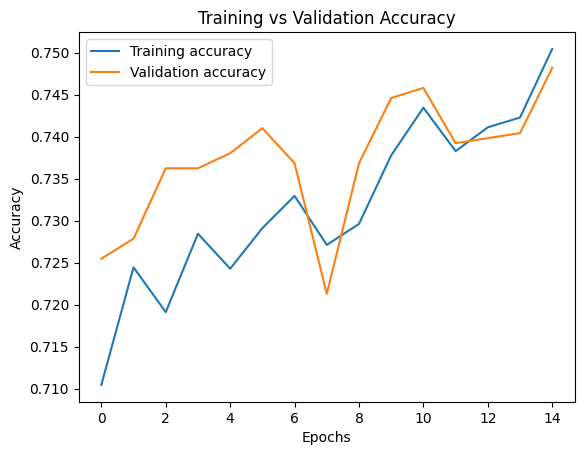

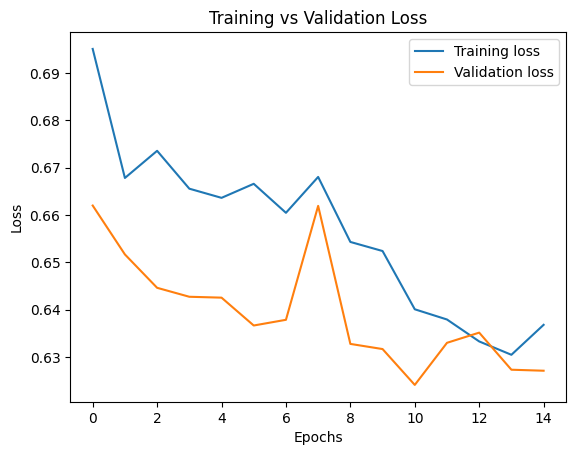

In [31]:
#  Plot Fine-Tuning Results
# plot_training_results(fine_tune_history, metric="accuracy")

plot_training_results(fine_tune_history)


In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Function to extract features using the hybrid model
def extract_features(model, generator):
    """
    Extract features from the hybrid model's Global Average Pooling layer.

    Parameters:
    - model: The trained hybrid model.
    - generator: The data generator (e.g., train_generator, validation_generator).

    Returns:
    - features: A numpy array of extracted features.
    - labels: Corresponding labels for the features.
    """
    # Extract features
    features = model.predict(generator, verbose=1)
    
    # Get the labels
    labels = generator.classes
    
    return features, labels

# Remove the dense and softmax layers to extract GAP features
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Extract features from training and validation data
train_features, train_labels = extract_features(feature_extractor, train_generator)
val_features, val_labels = extract_features(feature_extractor, validation_generator)

# Flatten the features if required by the classifier
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

print(f"Training feature shape: {train_features_flat.shape}")
print(f"Validation feature shape: {val_features_flat.shape}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 987s 5s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 288s 5s/step
Training feature shape: (5999, 512)
Validation feature shape: (1672, 512)


In [33]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed
knn.fit(train_features_flat, train_labels)

# Evaluate KNN
knn_predictions = knn.predict(val_features_flat)
knn_accuracy = accuracy_score(val_labels, knn_predictions)
print(f"KNN Validation Accuracy: {knn_accuracy:.2f}")

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators as needed
rf.fit(train_features_flat, train_labels)

# Evaluate RF
rf_predictions = rf.predict(val_features_flat)
rf_accuracy = accuracy_score(val_labels, rf_predictions)
print(f"Random Forest Validation Accuracy: {rf_accuracy:.2f}")


KNN Validation Accuracy: 0.25
Random Forest Validation Accuracy: 0.26
